In [60]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import norm,gamma,chi2, expon, t

from scipy.special import expit

In [126]:
# Load CSV file into a DataFrame
df = pd.read_csv('data/cumulative-area-burnt-by-wildfires-by-week.csv')
for i in range(0,13):
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].fillna(0, inplace=True)
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].div(10**6)

print(df.head())


        Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
0  Afghanistan  AFG     1                     0.000391   
1  Afghanistan  AFG     2                     0.000559   
2  Afghanistan  AFG     3                     0.000841   
3  Afghanistan  AFG     4                     0.000841   
4  Afghanistan  AFG     5                     0.000841   

   Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
0                          0.0                     0.000000   
1                          0.0                     0.000000   
2                          0.0                     0.000000   
3                          0.0                     0.000000   
4                          0.0                     0.000215   

   Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
0                     0.001246                     0.000000   
1                     0.002680                     0.000963   
2                     0.003539                     0.001181   
3                   

In [62]:
for i in range(1,13):
    df['Y'+str(2024-i)+'_Weekly_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].diff().fillna(df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'])
    
    

In [63]:
total_Cumulative_Area_Burnt=0
total_Weekly_Area_Burnt=0
for i in range(0,13):
    total_Cumulative_Area_Burnt=total_Cumulative_Area_Burnt+df['Y'+str(2024-i)+'_Cumulative_Area_Burnt']
    
for i in range(1,13):
    total_Weekly_Area_Burnt=total_Weekly_Area_Burnt+df['Y'+str(2024-i)+'_Weekly_Area_Burnt']
    
    
df['Total_Cumulative_Area_Burnt']=total_Cumulative_Area_Burnt
df['Avg_Cumulative_Area_Burnt']=df['Total_Cumulative_Area_Burnt']/(12)
df['Total_Weekly_Area_Burnt']=total_Weekly_Area_Burnt
df['Avg_Weekly_Area_Burnt']=df['Total_Weekly_Area_Burnt']/(13)


print(df)

            Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
0      Afghanistan  AFG     1                     0.000391   
1      Afghanistan  AFG     2                     0.000559   
2      Afghanistan  AFG     3                     0.000841   
3      Afghanistan  AFG     4                     0.000841   
4      Afghanistan  AFG     5                     0.000841   
...            ...  ...   ...                          ...   
13411     Zimbabwe  ZWE    48                     0.000000   
13412     Zimbabwe  ZWE    49                     0.000000   
13413     Zimbabwe  ZWE    50                     0.000000   
13414     Zimbabwe  ZWE    51                     0.000000   
13415     Zimbabwe  ZWE    52                     0.000000   

       Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
0                         0.000000                     0.000000   
1                         0.000000                     0.000000   
2                         0.000000                    

In [64]:
code = 'World'  # Replace 'AFG' with the code you want to filter by
filtered_df = df[df['Entity'] == code]
print(filtered_df)



      Entity      Code  Week  Y2024_Cumulative_Area_Burnt  \
13208  World  OWID_WRL     1                     7.706102   
13209  World  OWID_WRL     2                    16.405835   
13210  World  OWID_WRL     3                    25.033458   
13211  World  OWID_WRL     4                    33.018512   
13212  World  OWID_WRL     5                    39.035740   
13213  World  OWID_WRL     6                    45.517076   
13214  World  OWID_WRL     7                    51.166384   
13215  World  OWID_WRL     8                    57.281930   
13216  World  OWID_WRL     9                    68.291704   
13217  World  OWID_WRL    10                    79.310910   
13218  World  OWID_WRL    11                    87.835110   
13219  World  OWID_WRL    12                    89.475080   
13220  World  OWID_WRL    13                    89.475080   
13221  World  OWID_WRL    14                    89.475080   
13222  World  OWID_WRL    15                     0.000000   
13223  World  OWID_WRL  

In [65]:
filtered_df.Avg_Weekly_Area_Burnt

13208     7.432312
13209     7.176517
13210     6.639746
13211     6.796666
13212     6.364205
13213     5.988416
13214     5.131555
13215     4.904957
13216     4.906196
13217     5.147358
13218     5.521620
13219     5.840684
13220     6.010489
13221     5.473898
13222     5.747661
13223     5.274650
13224     4.746488
13225     4.215746
13226     4.213780
13227     3.942954
13228     4.298985
13229     4.668856
13230     6.064634
13231     6.597518
13232     6.822990
13233     7.431399
13234     8.354998
13235     9.086764
13236     9.546416
13237    10.094291
13238    10.596798
13239    11.037602
13240    11.550000
13241    11.459118
13242    11.706252
13243    12.393300
13244    12.150341
13245    10.206588
13246     8.392559
13247     7.585147
13248     7.579979
13249     7.075248
13250     6.606335
13251     6.101288
13252     5.583311
13253     5.094058
13254     4.811684
13255     5.209665
13256     6.198018
13257     7.533812
13258     8.004115
13259     7.719573
Name: Avg_We

In [66]:
Avg_Weekly_Area_Burnt_mean = filtered_df.Avg_Weekly_Area_Burnt.mean()
Avg_Weekly_Area_Burnt_std = filtered_df.Avg_Weekly_Area_Burnt.std()
Avg_Weekly_Area_Burnt_mean,Avg_Weekly_Area_Burnt_std

(7.0968757440828405, 2.309931416811632)

In [67]:
Avg_Cumulative_Area_Burnt_mean=filtered_df.Avg_Cumulative_Area_Burnt.mean()
Avg_Cumulative_Area_Burnt_std=filtered_df.Avg_Cumulative_Area_Burnt.std()
Avg_Cumulative_Area_Burnt_mean,Avg_Cumulative_Area_Burnt_std

(192.4319444679487, 120.79527854059383)

<AxesSubplot:>

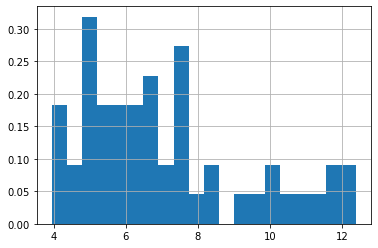

In [68]:
filtered_df.Avg_Weekly_Area_Burnt.hist(density=True, bins=20)

<AxesSubplot:>

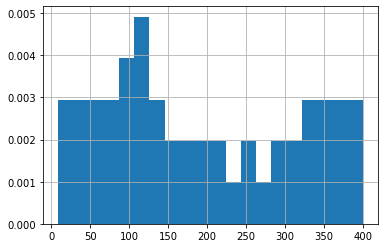

In [69]:
filtered_df.Avg_Cumulative_Area_Burnt.hist(density=True,bins=20)

In [70]:
#per year  the prob of avg area burning btw (200-250) hectre is <0.002, (80,120)>0.004
# means that in 'y' year in 'x' week prob of avg area burning btw (200-250) is <0.002, (80,120)>0.004

In [71]:
Avg_Weekly_Area_Burnt_alpha_mom = Avg_Weekly_Area_Burnt_mean ** 2 / Avg_Weekly_Area_Burnt_std
Avg_Weekly_Area_Burnt_beta_mom = Avg_Weekly_Area_Burnt_std / Avg_Weekly_Area_Burnt_mean
Avg_Weekly_Area_Burnt_alpha_mom, Avg_Weekly_Area_Burnt_beta_mom

(21.803957018113728, 0.325485678502626)

In [72]:
Avg_Cumulative_Area_Burnt_alpha_mom = Avg_Cumulative_Area_Burnt_mean ** 2 / Avg_Cumulative_Area_Burnt_std
Avg_Cumulative_Area_Burnt_beta_mom = Avg_Cumulative_Area_Burnt_std / Avg_Cumulative_Area_Burnt_mean
Avg_Cumulative_Area_Burnt_alpha_mom, Avg_Cumulative_Area_Burnt_beta_mom

(306.5521574940661, 0.6277298650937521)

2.287612715461937


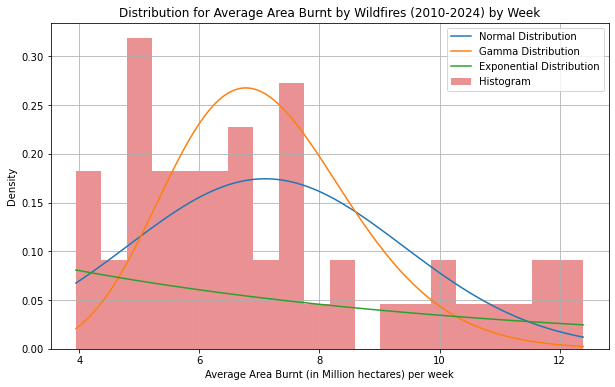

In [100]:


# Historical values
historical_values = filtered_df.Avg_Weekly_Area_Burnt

# Calculate mean and standard deviation
mean = np.mean(historical_values)
std_dev = np.std(historical_values)
print(std_dev)
# Generate data for the normal distribution curve
x = np.linspace(min(historical_values), max(historical_values), 100)
y = norm.pdf(x, mean, std_dev)
y1=gamma.pdf(x, a=Avg_Weekly_Area_Burnt_alpha_mom, scale=Avg_Weekly_Area_Burnt_beta_mom)
# y2 = lognorm.pdf(x, s=std_dev, scale=np.exp(mean))
y2 = expon.pdf(x, scale=mean)
# y2 = chi2.pdf(x, mean)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.plot(x, y1, label='Gamma Distribution')
plt.plot(x, y2, label='Exponential Distribution')
plt.hist(historical_values, bins=20, density=True, alpha=0.5, label='Histogram')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024) by Week')
plt.xlabel('Average Area Burnt (in Million hectares) per week')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [105]:

# # Historical values
# historical_values = filtered_df.Avg_Cumulative_Area_Burnt

# # Calculate mean and standard deviation
# mean = np.mean(historical_values)
# std_dev = np.std(historical_values)
# print(std_dev)
# # Generate data for the normal distribution curve
# x = np.linspace(min(historical_values), max(historical_values), 100)
# y = norm.pdf(x, mean, std_dev)
# y1=gamma.pdf(x, a=Avg_Cumulative_Area_Burnt_alpha_mom, scale=Avg_Cumulative_Area_Burnt_beta_mom)
# y2 = uniform.pdf(x,loc=min(historical_values), scale=max(historical_values)-min(historical_values))
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Normal Distribution')
# # plt.plot(x, y1, label='Gamma Distribution')
# plt.plot(x, y2, label='Uniform Distribution')
# plt.hist(historical_values, bins=20, density=True, alpha=0.5, label='Histogram')
# plt.title('Distribution for Average Cummulative Area Burnt by Wildfires (2010-2024) by Week')
# plt.xlabel('Average Cummulative Area Burnt (in Million hectares) per week')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.show()


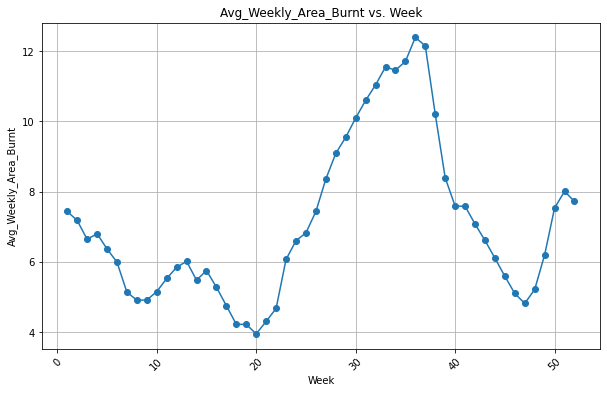

In [106]:

# Assuming 'Week' and 'Total' are columns in your DataFrame, and it is named 'df'
# You may need to adjust column names accordingly
# Also assuming df is sorted by week

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Week'], filtered_df['Avg_Weekly_Area_Burnt'], marker='o', linestyle='-')
plt.title('Avg_Weekly_Area_Burnt vs. Week')
plt.xlabel('Week')
plt.ylabel('Avg_Weekly_Area_Burnt')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.show()


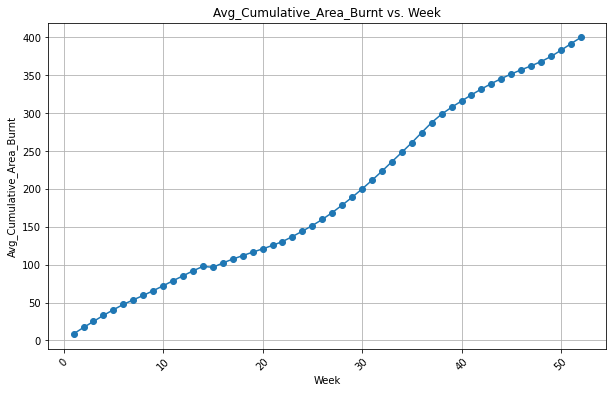

In [75]:
import matplotlib.pyplot as plt

# Assuming 'Week' and 'Total' are columns in your DataFrame, and it is named 'df'
# You may need to adjust column names accordingly
# Also assuming df is sorted by week

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Week'], filtered_df['Avg_Cumulative_Area_Burnt'], marker='o', linestyle='-')
plt.title('Avg_Cumulative_Area_Burnt vs. Week')
plt.xlabel('Week')
plt.ylabel('Avg_Cumulative_Area_Burnt')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.show()


In [76]:
# 
var_value = '_Weekly_Area_Burnt'
# var_value = '_Cumulative_Area_Burnt'

In [77]:
Wildfire_Cumulative_Area_Burnt_Per_Week_Dict = {}
count = 0
for index, row in filtered_df.iterrows():
    l = []
    for column_name in filtered_df.columns:
        if column_name.endswith(var_value):
            l.append(row[column_name])
    l = l[:-2]
    Wildfire_Cumulative_Area_Burnt_Per_Week_Dict['Week'+str(count+1)+var_value+'_Values'] = l
    count = count +1

In [104]:
# import matplotlib.pyplot as plt
# import numpy as np
# # Provided data
# # data = [7706102, 7273826, 6823054, 6243280, 8420206, 9185009, 8567571, 9048469, 9403529, 11393788, 9838285, 9556322, 867121]

# data = Wildfire_Cumulative_Area_Burnt_Per_Week_Dict.get('Week1'+var_value+'_Values')
# # Plotting the histogram
# plt.figure(figsize=(10, 6))

# plt.hist(data, bins=5,edgecolor='black', density=True, alpha=0.5, label='Histogram')

# plt.title('Histogram of World Data')
# plt.xlabel('Values')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()





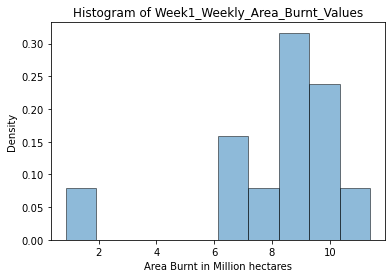

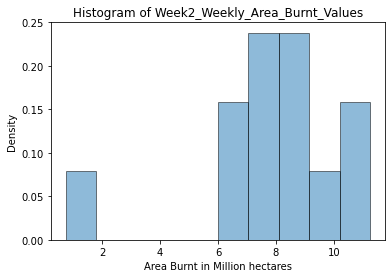

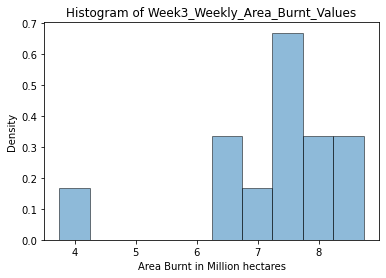

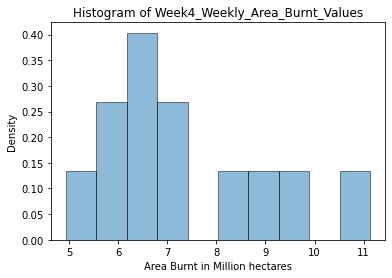

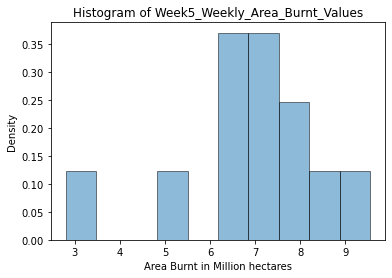

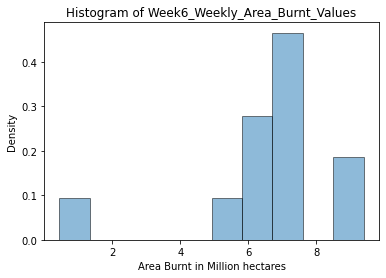

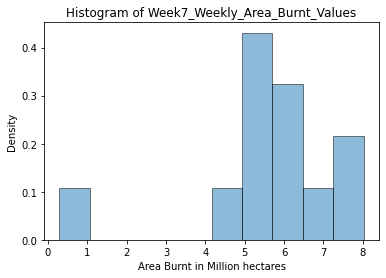

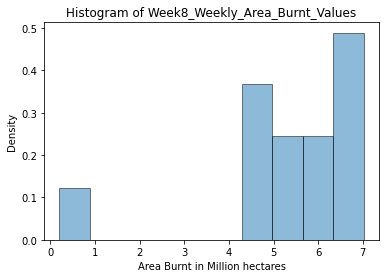

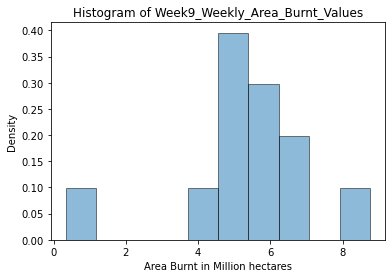

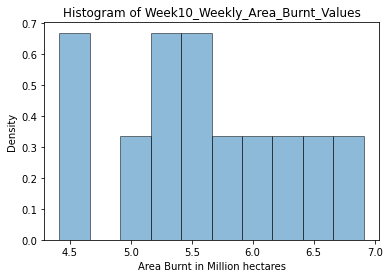

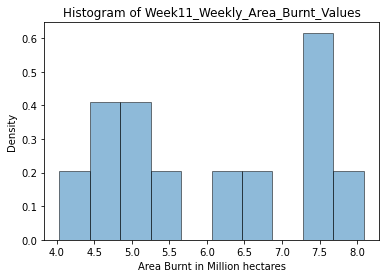

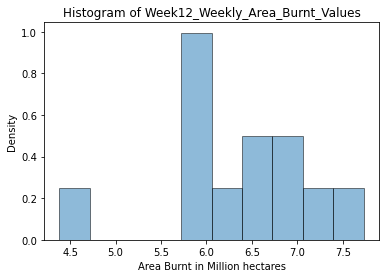

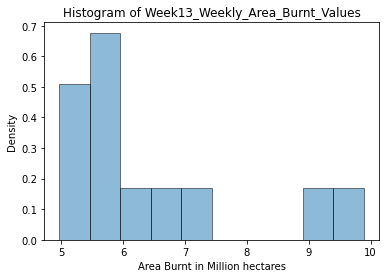

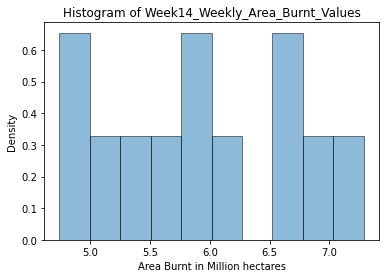

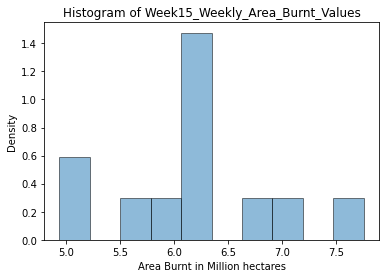

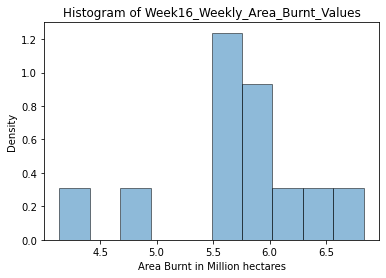

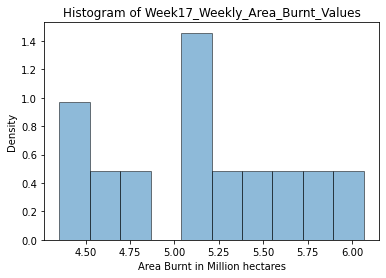

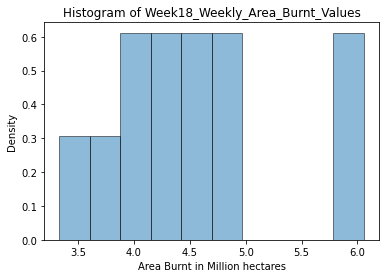

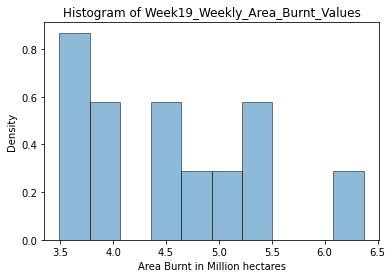

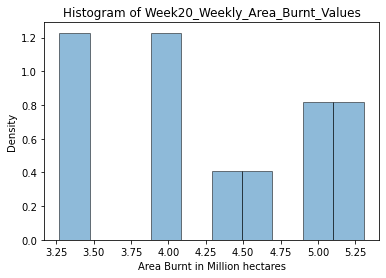

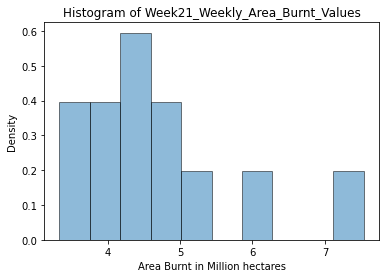

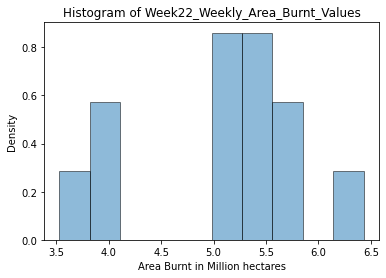

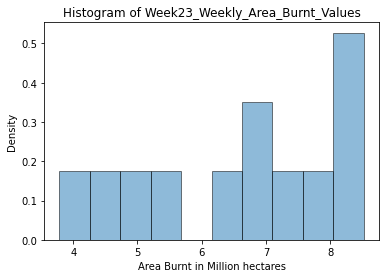

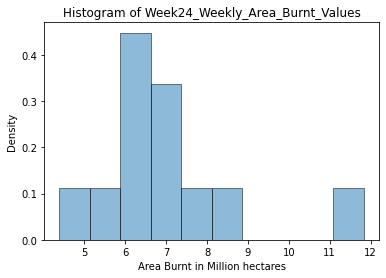

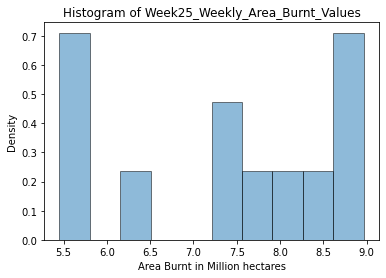

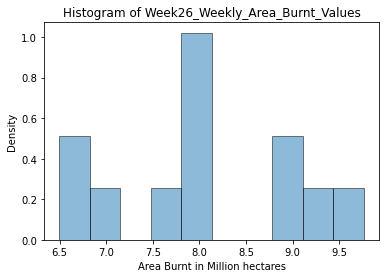

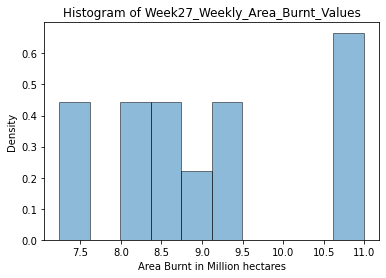

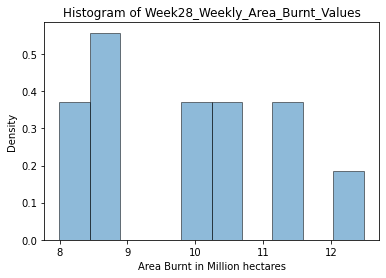

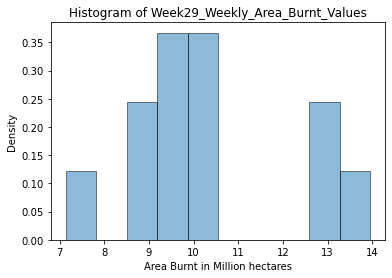

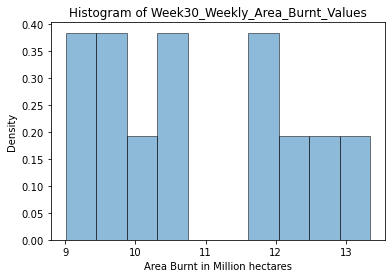

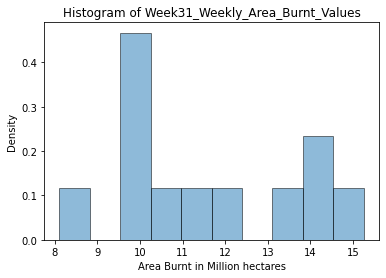

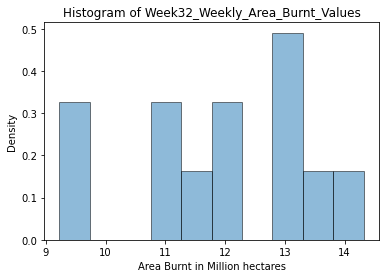

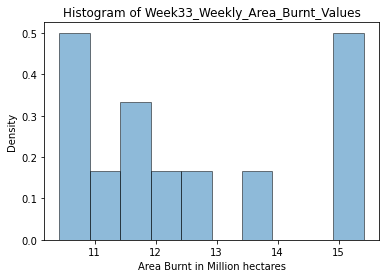

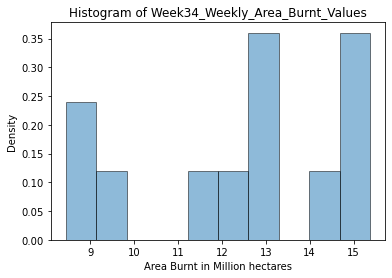

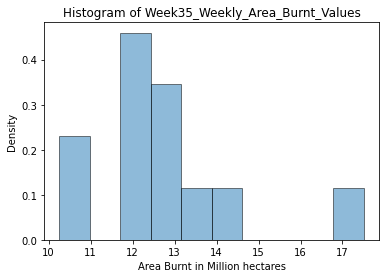

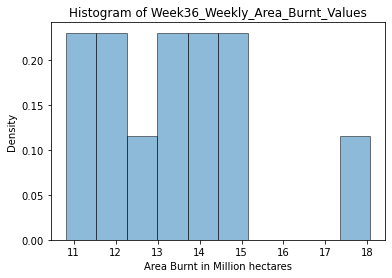

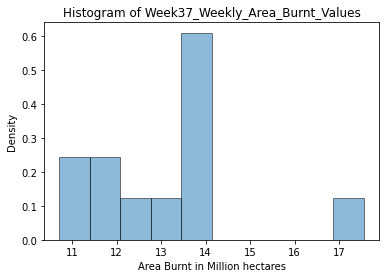

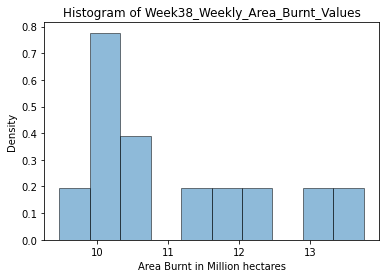

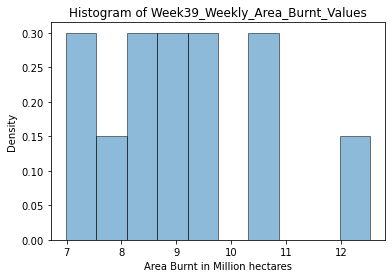

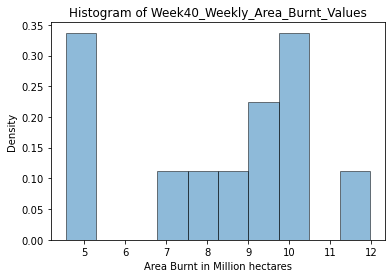

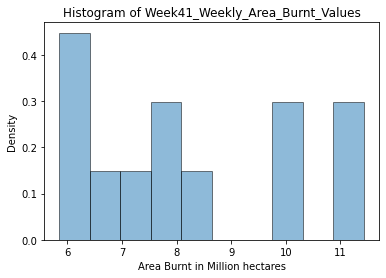

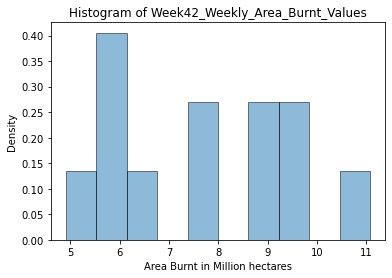

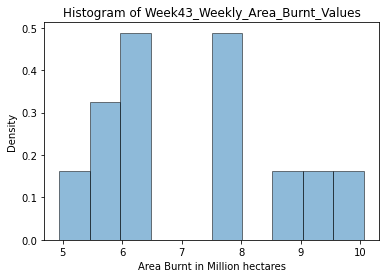

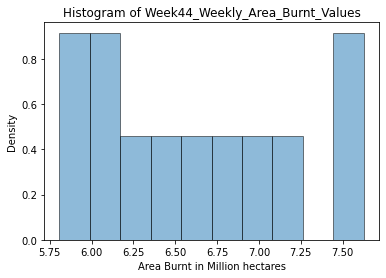

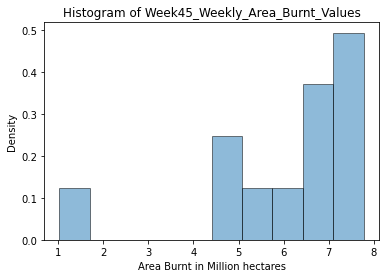

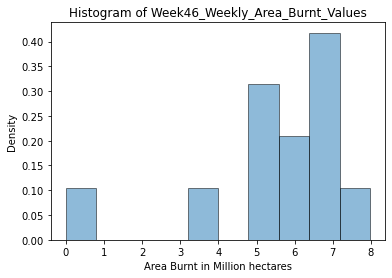

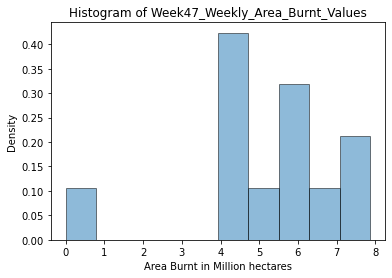

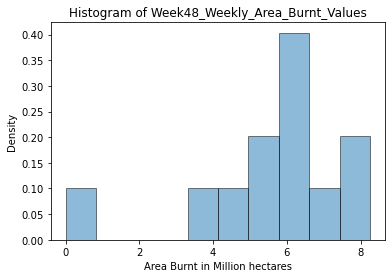

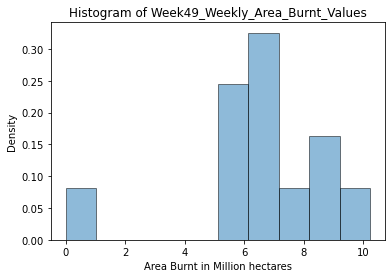

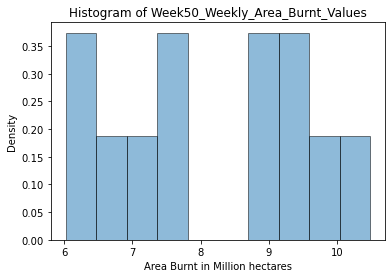

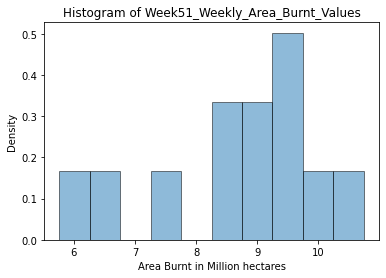

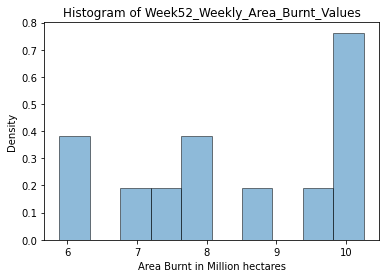

<Figure size 432x288 with 0 Axes>

In [103]:
for key, values in Wildfire_Cumulative_Area_Burnt_Per_Week_Dict.items():
    plt.hist(values, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
    plt.title('Histogram of ' + key)
    plt.xlabel('Area Burnt in Million hectares')
    plt.ylabel('Density')
    plt.grid(False)
    plt.show()

plt.tight_layout()

In [80]:
# The graph indicates that the probability of the area burned being between 0.9 and 1.2 in the 22nd week is 0.25
# week 1 lo 0.6 hecre land burn aye prob 0.75



In [116]:
Avg_Wildfire_Area_Burnt_Per_Year_Values=[]
for i in range(1,13):
    Avg_Wildfire_Area_Burnt_Per_Year_Values.append(filtered_df['Y'+str(2024-i)+var_value].sum()/12)

In [117]:
Avg_Wildfire_Area_Burnt_Per_Year_Values

[33.326933333333336,
 30.337618333333335,
 32.018861666666666,
 34.062261500000005,
 33.956671666666665,
 27.47459291666667,
 34.31470833333333,
 34.678599999999996,
 36.95930416666666,
 33.85835,
 32.3302025,
 36.4725625]

In [119]:
Avg_Wildfire_Area_Burnt_Per_Year_Values_mean = np.mean(Avg_Wildfire_Area_Burnt_Per_Year_Values)
Avg_Wildfire_Area_Burnt_Per_Year_Values_std = np.std(Avg_Wildfire_Area_Burnt_Per_Year_Values)
Per_year_Avg_Weekly_Area_Burnt_alpha_mom = Avg_Wildfire_Area_Burnt_Per_Year_Values_mean ** 2 / Avg_Wildfire_Area_Burnt_Per_Year_Values_std
Per_year_Avg_Weekly_Area_Burnt_beta_mom = Avg_Wildfire_Area_Burnt_Per_Year_Values_std / Avg_Wildfire_Area_Burnt_Per_Year_Values_mean
Per_year_Avg_Weekly_Area_Burnt_alpha_mom, Per_year_Avg_Weekly_Area_Burnt_beta_mom

(450.0188476807782, 0.07403220794288799)

33.31588890972221 2.466448815566711


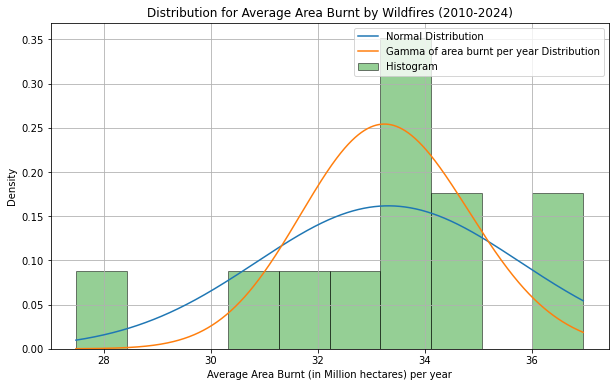

In [125]:
data = Avg_Wildfire_Area_Burnt_Per_Year_Values

l_mean = Avg_Wildfire_Area_Burnt_Per_Year_Values_mean
l_std = Avg_Wildfire_Area_Burnt_Per_Year_Values_std
print(l_mean,l_std)
# Plotting the histogram

x = np.linspace(min(data), max(data), 1000)

y = norm.pdf(x, l_mean, l_std)
y1=gamma.pdf(x, a=Per_year_Avg_Weekly_Area_Burnt_alpha_mom, scale=Per_year_Avg_Weekly_Area_Burnt_beta_mom)
y2 = expon.pdf(x, scale=l_mean)
# student_t_pdf = t.pdf(x, 3)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.plot(x, y1, label='Gamma of area burnt per year Distribution')
# plt.plot(x, y2, label='Exponential Distribution')
# plt.plot(x, student_t_pdf, label='Student T Distribution')
plt.hist(data, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024)')
plt.xlabel('Average Area Burnt (in Million hectares) per year')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
